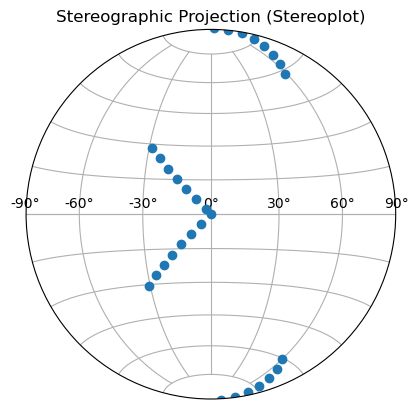

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.projections import register_projection
from matplotlib.projections.geo import LambertAxes
from matplotlib.ticker import FixedLocator
from matplotlib.transforms import Affine2D

class HalfLambertAxes(LambertAxes):
    """
    A custom projection class based on LambertAxes, representing a half-sphere projection.

    This class includes methods for configuring the grid and applying an affine transformation
    specific to the half-sphere Lambert projection.
    """

    def set_longitude_grid(self, degrees):
        """
        Sets the longitude grid interval.

        Parameters:
        ----------
        degrees : float
            The interval in degrees between each longitude grid line.
        
        This method sets up a grid with tick marks at specified longitude intervals, 
        using a fixed locator for the major ticks and a custom formatter.
        """
        grid = np.arange(-90, 90 + degrees, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def _get_affine_transform(self):
        """
        Returns an affine transformation for scaling and translating the half-sphere projection.

        Returns:
        -------
        Affine2D : Transformation for scaling and translating the plot within its axis limits.
        """
        return Affine2D().scale(0.356).translate(0.5, 0.5)

class Stereoplot(HalfLambertAxes):
    """
    A stereographic projection class for plotting data on a stereonet.

    Inherits from HalfLambertAxes to represent a stereographic view with options for specifying
    the center latitude, center longitude, and rotation. This projection is based on the `mplstereonet` project
    (https://github.com/joferkington/mplstereonet), which provides robust
    implementations for geological stereographic plots. This type of projection
    is valuable for visualizing orientation data in geoscience and related
    fields.
    """

    name = "stereoplot"
    _default_center_latitude = 0
    _default_center_longitude = 0

    def __init__(self, *args, center_latitude=None, center_longitude=None, rotation=0, **kwargs):
        """
        Initializes the Stereoplot projection with optional parameters for center and rotation.

        Parameters:
        ----------
        center_latitude : float, optional
            Latitude for the center of the projection, defaults to 0.
        center_longitude : float, optional
            Longitude for the center of the projection, defaults to 0.
        rotation : float, optional
            Rotation angle in degrees to apply to the projection, defaults to 0.
        """
        self.horizon = np.radians(90)
        self._rotation = -np.radians(rotation)

        center_latitude = center_latitude or self._default_center_latitude
        center_longitude = center_longitude or self._default_center_longitude

        kwargs["center_latitude"] = center_latitude
        kwargs["center_longitude"] = center_longitude
        
        super().__init__(*args, **kwargs)

register_projection(Stereoplot)

# Generate a sample stereonet projection plot
fig, ax = plt.subplots(subplot_kw=dict(projection="stereoplot"))

# Sample data for azimuth (0 to 45 degrees) and inclination (0 to 45 degrees)
azimuth = np.linspace(0, 45, 30)
inclination = np.linspace(0, 45, 30)

# Plot the data on the stereonet
ax.plot(azimuth, inclination, 'o', label='Projection Points')
ax.set_title("Stereographic Projection (Stereoplot)")
plt.grid()
plt.show()
